# Probablistic Programming - Chapter 1

These are notes based on Chapter 1 of [Cam Davidson Pilon's Probabilistic Programming for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).

* Bayesian world-view interprets probability as measure of believability in an event, as opposed to long-term frequency of events.  Instead, probabilitiy represents confidence in an event - 0 being no confidence (impossible to happen), 1 being full confidence (certain it will happen).
    * Makes more sense for situations that should not be generalized to long-term (eg. presidential elections).
    * Allows for perspective to be baked into calculations, based on prior information and biases available to observer.
* **Prior**: $P(A)$; **posterior**: $P(A|X)$, where $X$ is evidence.
    * Frequentists typically report a summary statistic + error bars on that statistic.  Bayesians report a summary probabilitiy distribution (possibly using corresponding summary statistics).
    * For large $N$, Bayesian and Frequentist methods often approach one another.
* Bayes's Theorem:

$$
P(A|X) = \frac{P(X|A)P(A)}{P(X)}
$$

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Example: Mandatory Coin Flip

- The likelihood function for $p$ given $n$ Bernoulli trials where $k$ of them came up heads has Binomial form:

$$
\mathcal{L}(p|k) = P(k|p) = {n\choose k}p^k(1-p)^{n-k}
$$

- Note that the likelihood is not equal to $P(p|k)$ - as [Wikipedia notes](https://en.wikipedia.org/wiki/Likelihood_function), it " describes a hypersurface whose peak, if it exists, represents the combination of model parameter values that maximize the probability of drawing the sample obtained."

- The [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for this is the Beta function ([proof](https://en.wikipedia.org/wiki/Conjugate_prior#Example)); if we choose this form (and set hyperparameters $\alpha = \beta = 2$), the posterior is

$$
P(p|k) \propto \beta (1 + k, 1 + n - k)
$$

- Will be described further in subsequent chapters.

<IPython.core.display.Javascript object>


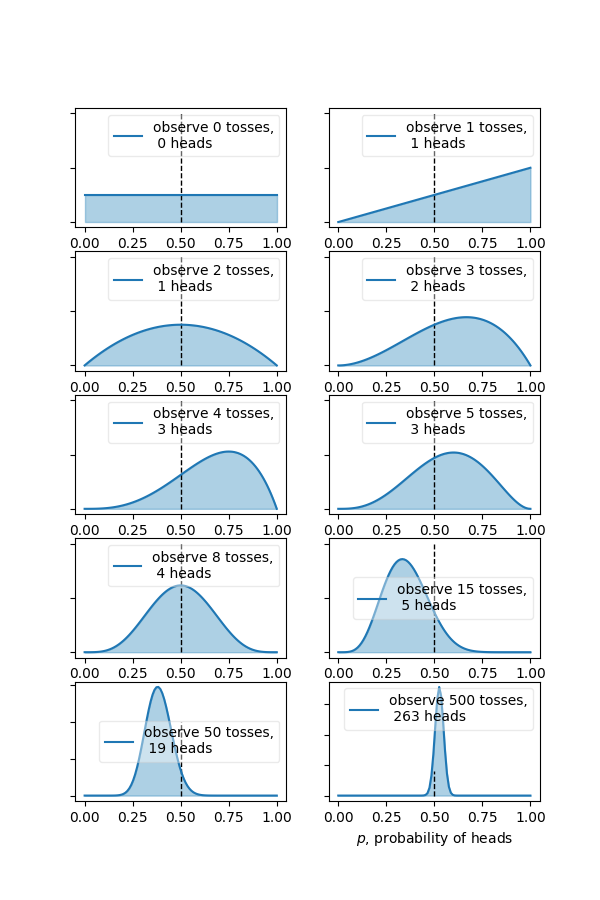

In [2]:
# Generate a bunch 
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

plt.figure(figsize=(6, 9))

for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials)/2, 2, k+1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    # Analytically calculated posterior using binomial conjugate prior.
    y = stats.beta.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4);

## Example: Bug or Sweet Feature?
* $A$ is event that our code has no bugs.  $X$ is event that code passes all debugging tests.  Given that our tests pass, what is the probability there are no bugs, i.e. what is $P(A|X)$?
* Set our prior to be $P(A) = p \in [0, 1]$.  $P(X|A) = 1$, obviously, but $P(X|~A)$ depends on our physical system.  For simplicity, we set this to $0.5$.  Then:

$$
P(X) = P(X|A)p + P(X|\sim A)(1-p)
$$

* By Bayes's theorem:

\begin{eqnarray}
P(A|X) &=& \frac{P(X|A)P(A)}{P(X)} \\
&=& \frac{p}{p + (1 - p)/2} = \frac{2p}{1 + p}
\end{eqnarray}

* Since our prior is variable, how does our posterior look depending on how we set it?

<IPython.core.display.Javascript object>


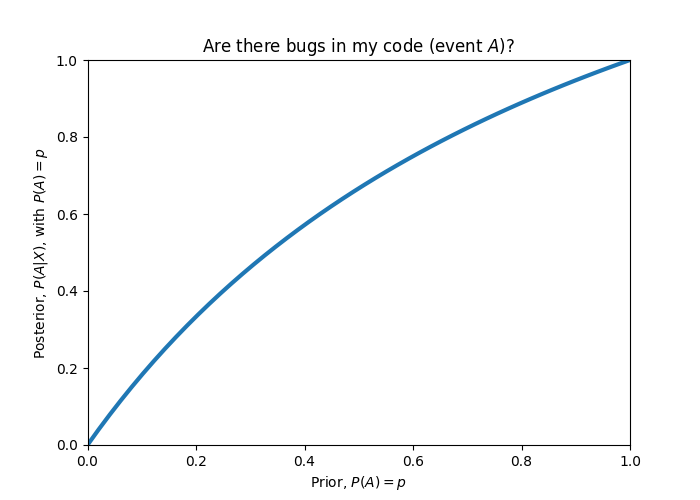

In [3]:
fig, ax = plt.subplots(figsize=(7, 5))
p = np.linspace(0, 1, 50)
ax.plot(p, 2 * p / (1 + p), lw=3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Prior, $P(A) = p$")
ax.set_ylabel("Posterior, $P(A|X)$, with $P(A) = p$")
ax.set_title("Are there bugs in my code (event $A$)?");

## Example: Inferring Behaviour from Text-Message Data

* Examine some text message data from Cam.

In [4]:
import pandas as pd

data_url = ("https://raw.githubusercontent.com/CamDavidsonPilon/"
            "Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/"
            "5388010faa750814a8dc88b6477738a9ce7ae5d7/"
            "Chapter1_Introduction/data/txtdata.csv")

texting_data = pd.read_csv(data_url, header=None, names=['number of texts'], dtype=int)
texting_data['day'] = np.arange(texting_data.shape[0], dtype=int)

<IPython.core.display.Javascript object>


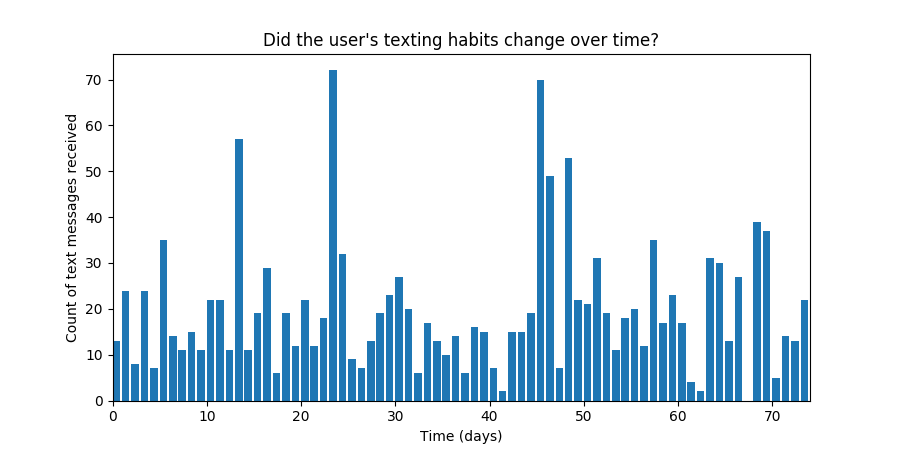

In [5]:
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.bar(texting_data['day'], texting_data['number of texts'], align='edge')
ax.set_xlabel("Time (days)")
ax.set_ylabel("Count of text messages received")
ax.set_title("Did the user's texting habits change over time?")
ax.set_xlim(0, texting_data.shape[0]);

* Simple assumption: count data is Poisson, so count of text messages on day $i$ is

$$
C_i \sim \mathrm{Poisson}(\lambda(t))
$$

* In place of a full Poisson regression, we can use a two-step model where:

$$
\lambda(t) = \cases{\lambda_1\,\,\mathrm{if}\,\,t \leq \tau \\ \lambda_2\,\,\mathrm{else}}
$$

* We will investigate if $\lambda_1$ has the same posterior distribution as $\lambda_2$.
* To get $P(\lambda_1|\mathrm{data})$, we'll need a prior for $\lambda_1$ and $\lambda_2$.  We can choose

$$
\lambda \sim \mathrm{Exp}(\alpha)
$$

* For $\alpha$, we note that the expectation of an exponential RV $E[\lambda|\alpha] = \frac{1}{\alpha}$, and the expectation of a Poisson RV $E[C|\lambda] = \lambda$, so a sensible guess for $\alpha$ is $T / N$, the mean number of texts per day.
* For $\tau$, let's assume a discrete uniform RV

$$
\tau \sim \mathrm{DiscreteUniform}(0, 70)
$$

In [6]:
import pymc3 as pm
import theano.tensor as tt

# Create stochastic independent variables for lambda_1, lambda_2, tau.
with pm.Model() as model:
    alpha = 1.0 / texting_data['number of texts'].mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=texting_data['day'].max())

In [7]:
# Create switch between lambda_1 and 2.
with model:
    idx = texting_data['day'].values
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [8]:
# Create dependent variable based on independent ones.
with model:
    observation = pm.Poisson("obs", lambda_, observed=texting_data['number of texts'].values)

In [9]:
# Run a Metropolis-Hastings algorithm to sample the posterior.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5344.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
# Obtain samples.
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

<IPython.core.display.Javascript object>


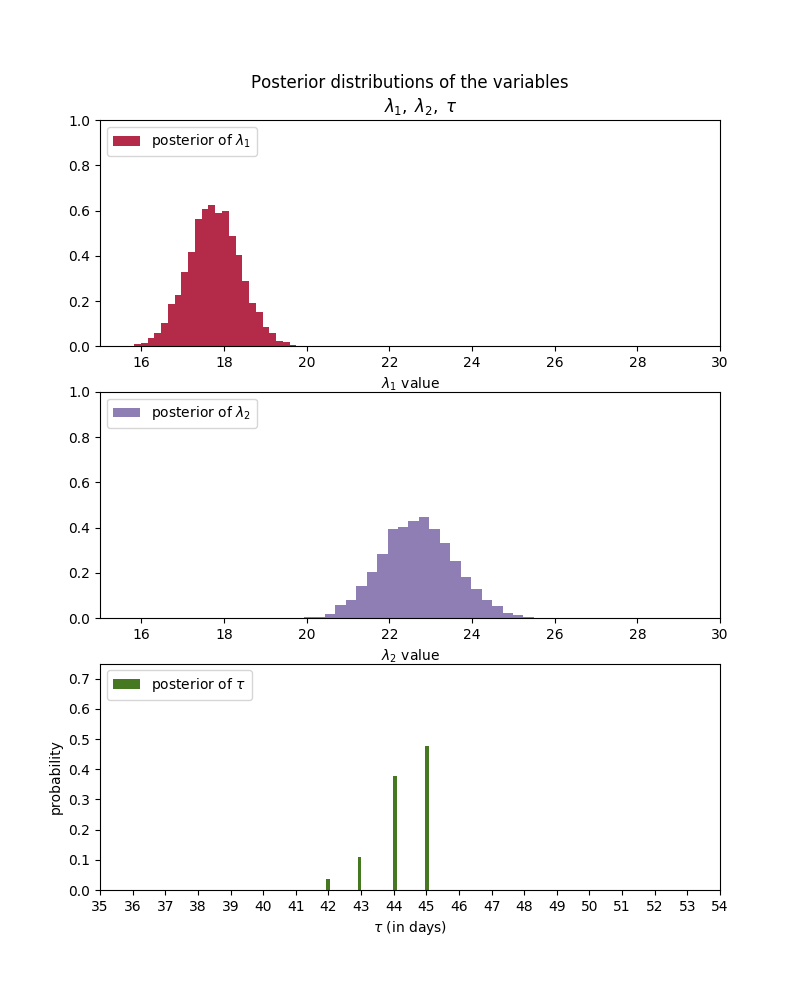

In [11]:
plt.figure(figsize=(8, 10))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=texting_data.shape[0], alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(texting_data['day'].values)

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, texting_data.shape[0] - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

* With the posterior, one could report credible intervals that would lend credence to the idea that $\lambda_1$ and $\lambda_2$ are different.
* Moreover, the $\tau$ distribution is peaked at around 45 days; if there was no change in $\lambda$, we'd expect a more spread out distribution.
* How to calculate the expected number of texts per day?  The probability "density" function (it's no longer a pure mass function since $P(\lambda)$ is continuous) $f(C = x)$ is:

$$
f(C=x) = P(x|\lambda)P(\lambda)
$$

* Based on the conditional probability rule $P(B) = \sum P(B|A)P(A)$, it should look like (moving $d\lambda$ to the front of the integrand for clarity, and using):

\begin{eqnarray}
E[C] &=& \int_0^\infty d\lambda(t)  P(\lambda(t))\sum_{x=0}^\infty x P(C = x|\lambda) \\
&=& \int_0^\infty d\lambda(t) P(\lambda(t)) E[C(\lambda)] \\
&=& \int_0^\infty d\lambda(t) P(\lambda(t)) \lambda \\
&=& E[\lambda(t)]
\end{eqnarray}

* In practice, we can estimate this with the sample mean

In [20]:
t = np.arange(75.)
n = np.empty(t.shape[0])
for i in range(t.shape[0]):
    # Eg. for day 45, E[\lambda] \approx \sum \lambda_1 P(\lambda_1) P(t < \tau) + \lambda P(\lambda_2) P(t >= \tau)
    # The strategy for estimating E[\lambda] is to generate samples of \lambda by generating samples of \tau,
    # \lambda_1 and \lambda_2.  For each sample where \tau > day, we pick the \lambda_1 sample; otherwise we pick \lambda_2.
    t_below_tau = t[i] < tau_samples
    n[i] = (lambda_1_samples[t_below_tau].sum() + lambda_2_samples[~t_below_tau].sum()) / tau_samples.shape[0]

<IPython.core.display.Javascript object>


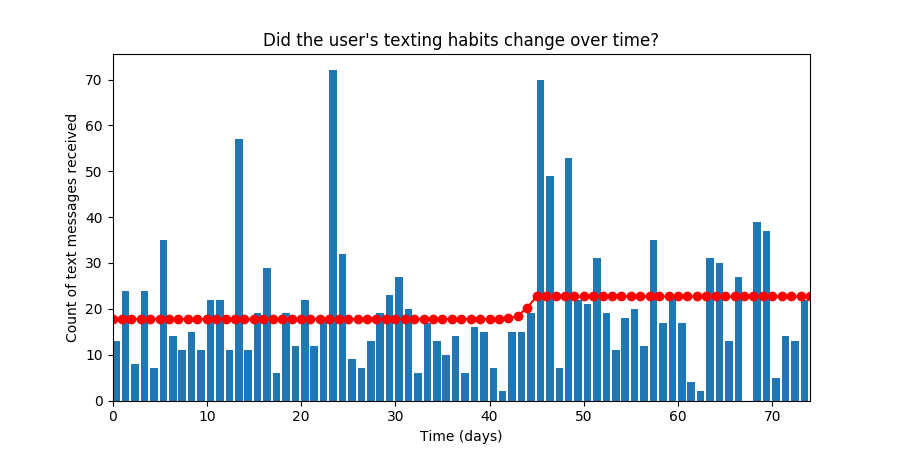

In [22]:
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.bar(texting_data['day'], texting_data['number of texts'], align='edge')
ax.plot(t, n, 'ro-')
ax.set_xlabel("Time (days)")
ax.set_ylabel("Count of text messages received")
ax.set_title("Did the user's texting habits change over time?")
ax.set_xlim(0, texting_data.shape[0]);

# Exercises

### 1: Using `lambda_1_samples` and `lambda_2_samples`, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

- $E[X]$ can be approximated by the sample mean.

In [23]:
lambda_1_samples.mean()

17.760113878819425

In [24]:
lambda_2_samples.mean()

22.692422882685047

### 2. What is the expected percentage increase in text-message rates?

- We're now considering the ratio of two random variables: $E[Y / X]$, which can be approximated by the sample mean of the ratio.
- **If $Y$ and $X$ are independent**, then $E[Y / X] = E[Y]E[1/X]$, and, as Cam notes, not $E[Y] / E[X]$.  However, the posterior of $\lambda_1$ **is** dependent on that of $\tau$, since if $\tau$ is 70 we'd expect it to be more likely that $\lambda_1$ and $\lambda_2$ are close together.

In [45]:
(lambda_2_samples / lambda_1_samples).mean()

1.2793779461687773

### 3. What is the mean of $\lambda_1$ given that we know $\tau$ is less than 45?

* As mentioned before, $P(\lambda_1)$ is dependent on $\tau$, so we only consider draws where $\tau < 45$.

In [49]:
(lambda_1_samples[tau_samples < 45.]).mean()

17.7618373090353

In [50]:
# For the hell of it, try tau_samples > 45 as well
(lambda_1_samples[tau_samples > 45.]).mean()

19.142164774361984